In [6]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import resampy
from utilities import upsampling
from filter_design import rrcos_pulseshaping_freq
try:
    import cupy as cp
    import cusignal
    is_cuda_avaliable = True
except ImportError:
    is_cuda_avaliable = False
    
class Signal(object):
    
    def __init__(self,qam_order,baudrate,sps,sps_in_fiber,symbol_length,pol_number):
        '''
            qam_order
            message 2d-array
            all 2d-array
        '''
        self.qam_order = qam_order
        self.message = None
        self.baudrate = baudrate
        self.sps = sps
        self.sps_in_fiber = sps_in_fiber
        self.ds = None
        self.ds_in_fiber = None
        self.symbol = None
        self.freq = None 
        self.symbol_length = symbol_length
        self.pol_number = pol_number
        self.__constl = None
        self.is_on_cuda = False
        
        
    @property
    def fs_in_fiber(self):
        return self.sps_in_fiber * self.baudrate
    
    def prepare(self):
        raise NotImplementedError
        
    def __getitem__(self,value):
        return self.ds_in_fiber[value]
    
    def __setitem__(self,key,value):
        self.ds_in_fiber[key] = value
        
    @property
    def shape(self):
        return self.ds_in_fiber.shape
    
    def psd(self):
        if self.is_on_cuda:
            self.cpu()
            plt.psd(self.ds_in_fiber[0],NFFT=16384,Fs = self.fs_in_fiber,scale_by_freq=True)
            self.cuda()
   
    @property
    def constl(self):
        return self.__constl
    
    @constl.setter
    def constl(self,value):
        self.__constl = value
    
    def scatterplot(self,sps):
        if self.is_on_cuda:
            self.ds_in_fiber = cp.asnumpy(self.ds_in_fiber)
        fignumber = self.shape[0]
        fig,axes = plt.subplots(nrows = 1,ncols = fignumber)
        for ith,ax in enumerate(axes):
            ax.scatter(self.ds_in_fiber[ith,::sps].real,self.ds_in_fiber[ith,::sps].imag,s=1,c='b')
            ax.set_aspect('equal', 'box')

            ax.set_xlim([self.ds_in_fiber[ith,::sps].real.min()-0.1,self.ds_in_fiber[ith,::sps].real.max()+0.1])
            ax.set_ylim([self.ds_in_fiber[ith,::sps].imag.min()-0.1,self.ds_in_fiber[ith,::sps].imag.max()+0.1])

        plt.tight_layout()
        plt.show()
        if self.is_on_cuda:
            self.ds_in_fiber = cp.array(self.ds_in_fiber)
            
    @property
    def samples(self):
        return self.ds_in_fiber
    @samples.setter
    def samples(self,value):
        self.ds_in_fiber = value
    @property
    def fs(self):
        return self.baudrate * self.sps
    
    def cuda(self):
        if not is_cuda_avaliable:
            return
        
        else:
            self.ds_in_fiber = cp.array(self.ds_in_fiber)
            self.ds = cp.array(self.ds)
            self.is_on_cuda = True
        
        return self
        
    def cpu(self):
        if not self.is_on_cuda:
            return
        
        else:
            
            self.ds_in_fiber = cp.asnumpy(self.ds_in_fiber)
            self.ds = cp.asnumpy(self.ds_in_fiber)
            self.is_on_cuda = False
        return self
        
        

In [7]:
class QamSignal(Signal):
    def __init__(self,qamorder,baudrate,sps,sps_in_fiber,symbol_length,pol_number):
        super().__init__(qamorder,baudrate,sps,sps_in_fiber,symbol_length,pol_number)
        self.message = np.random.randint(low=0,high=self.qam_order,size=((self.pol_number,self.symbol_length)))
        self.map()

    def map(self):
        import joblib
        constl = joblib.load('constl')[self.qam_order][0]
        self.symbol = np.zeros_like(self.message,dtype=np.complex)
        for row_index,sym in enumerate(self.symbol):
            for i in range(self.qam_order):
                sym[self.message[row_index] == i] = constl[i]
        
        self.constl = constl
        
    def prepare(self,roll_off,is_cuda=False):
        
        self.ds = upsampling(self.symbol,self.sps)
        self.ds_in_fiber = np.zeros((self.pol_number,self.symbol.shape[1]*self.sps_in_fiber),dtype = self.symbol.dtype)
        if is_cuda:
            self.cuda()
            
        for index,row in enumerate(self.ds):
            row[:] = rrcos_pulseshaping_freq(row,self.fs,1/self.baudrate,roll_off,self.is_on_cuda)
            if not self.is_on_cuda:
                self.ds_in_fiber[index] = resampy.resample(row,self.sps,self.sps_in_fiber,filter='kaiser_fast') 
            else:
                self.ds_in_fiber[index] = cusignal.resample_poly(row,self.sps_in_fiber/self.sps,1,axis=-1)
            
    @property 
    def time_vector(self):
        return 1/self.fs_in_fiber * np.arange(self.ds_in_fiber.shape[1])


 

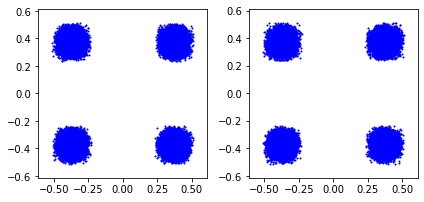

In [178]:
signal = QamSignal(4,35e9,2,4,65536,2)
signal.prepare(0.2,True)
from receiver_dsp import matched_filter

signal.scatterplot(4)


In [10]:

class Laser(object):
    
    def __init__(self,linewidth,is_phase_noise,freq):
        '''
            linewidth:hz
            freq:hz
        '''
        self.linewidth = linewidth
        self.is_phase_noise = is_phase_noise
        self.freq = freq
        self.is_on_cuda = False
        
    def phase_noise(self,signal):
        
        if self.is_on_cuda:
            import cupy as np
        else:
            import numpy as np
    
        var = 2*np.pi*self.linewidth/signal.fs_in_fiber
        f = np.random.normal(scale=np.sqrt(var), size=signal[:].shape)
        for row in f:
            row[0] = (np.random.rand(1)*2*np.pi - np.pi)[0]
        return np.cumsum(f, axis=1)
    
    def prop(self,signal):
        signal.freq = self.freq
        self.is_on_cuda = signal.is_on_cuda
        
        if self.is_on_cuda:
            import cupy as np
        else:
            import numpy as np
            
        if self.is_phase_noise:
            self.phase_noise = self.phase_noise(signal)
            signal[:] = signal[:] * np.exp(1j*self.phase_noise)
        return signal
    
    def plot_phase_noise(self):
        
        if self.is_phase_noise:
            if self.is_on_cuda:
                import cupy as cp
                self.phase_noise = cp.asnumpy(self.phase_noise)
            
            fig,axes = plt.subplots(figsize = (10,2),nrows = 1,ncols = self.phase_noise.shape[0])
            for ith,ax in enumerate(axes):
                ax.plot(self.phase_noise[ith],c='b',lw=2)

                  
        plt.tight_layout()
        plt.show()

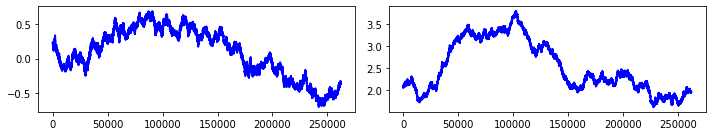

In [180]:
laser = Laser(100e3,True,193.1e12)
signal = laser.prop(signal)
laser.plot_phase_noise()

In [4]:
class WSS(object):

    def __init__(self, frequency_offset, bandwidth, oft):

        '''

        :param frequency_offset: value away from center [GHz]
        :param bandwidth: 3-db Bandwidth [Ghz]
        :param oft:GHZ
        '''
        self.frequency_offset = frequency_offset/1e9
        self.bandwidth = bandwidth/1e9
        self.oft = oft/1e9
        self.H = None
        self.freq = None
        self.is_on_cuda = False
        
    def prop(self, signal):

        sample = signal[:]
        self.is_on_cuda = signal.is_on_cuda
        
        if self.is_on_cuda:
            import cupy as np
            
        else:
            import numpy as np

        freq = np.fft.fftfreq(len(sample[0, :]), 1 / signal.fs_in_fiber)
        freq = freq / 1e9
        
        self.freq = freq
        self.__get_transfer_function(freq)

        for i in range(sample.shape[0]):
            sample[i, :] = np.fft.ifft(np.fft.fft(sample[i, :]) * self.H)

        signal[:] = sample
        return signal

    
    def __get_transfer_function(self, freq_vector):
        if self.is_on_cuda:
            import cupy as np
            from cupyx.scipy.special import erf
        else:
            import numpy as np
            from scipy.special import erf
            
        delta = self.oft / 2 / np.sqrt(2 * np.log(2))

        H = 0.5 * delta * np.sqrt(2 * np.pi) * (
                erf((self.bandwidth / 2 - (freq_vector - self.frequency_offset)) / np.sqrt(2) / delta) - erf(
            (-self.bandwidth / 2 - (freq_vector - self.frequency_offset)) / np.sqrt(2) / delta))

        H = H / np.max(H)

        self.H = H
        

    def plot_transfer_function(self, freq=None):
        import matplotlib.pyplot as plt
        if self.H is None:
            self.__get_transfer_function(freq)
            self.freq = freq
        if self.is_on_cuda:
            import cupy as cp
            self.H = cp.asnumpy(self.H)
            self.freq = cp.asnumpy(self.freq)
        
        index = self.H > 0.001
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.scatter(self.freq[index], np.abs(self.H[index]), color='b', marker='o')
        plt.xlabel('GHz')
        plt.ylabel('Amplitude')
        plt.title("without log")
        plt.subplot(122)
        plt.scatter(self.freq[index], 10 * np.log10(np.abs(self.H[index])), color='b', marker='o')
        plt.xlabel('GHz')
        plt.ylabel('Amplitude')
        plt.title("with log")
        plt.show()
        if self.is_on_cuda:
            self.H = cp.array(self.H)
            self.freq = cp.array(self.freq)
        
            

    def __str__(self):

        string = f'the center_frequency is {0 + self.frequency_offset}[GHZ] \t\n' \
            f'the 3-db bandwidth is {self.bandwidth}[GHz]\t\n' \
            f'the otf is {self.oft} [GHz] \t\n'
        return string

    def __repr__(self):
        return self.__str__()

    

In [14]:
import pdb
class WdmSignal(object):
    def __init__(self,symbols,wdm_samples,freq,is_on_cuda,fs_in_fiber):
        self.symbols = symbols
        self.wdm_samples = wdm_samples
        
        self.relative_freq = freq
        self.is_on_cuda = is_on_cuda
        self.fs_in_fiber = fs_in_fiber
        self.fs = fs_in_fiber
        
        self.wdm_comb_config = None
        self.baudrates = None
        self.qam_orders = None
        
        if self.is_on_cuda:
            import cupy as cp
            self.fs_in_fiber = cp.asnumpy(self.fs_in_fiber)
            self.wdm_comb_config = cp.asnumpy(self.wdm_comb_config)
            
            self.relative_freq = cp.asnumpy(self.relative_freq)
            
    def cuda(self):
        if self.is_on_cuda:
            return self
        
        else:
            try:
                import cupy as cp
            except ImportError:
                return self
            
            self.wdm_samples = cp.array(self.wdm_samples)
            self.is_on_cuda = True
            
        return self
    
    def cpu(self):
        if not self.is_on_cuda:
            return self
        else:
            import cupy as cp
            self.wdm_samples = cp.asnumpy(self.wdm_samples)
            self.fs_in_fiber = cp.asnumpy(self.fs_in_fiber)
            self.is_on_cuda = False
        return self
    
        
    def __getitem__(self,value):
        return self.wdm_samples[value]
    
    def __setitem__(self,key,value):
        self.wdm_samples[key] = value
        
    def psd(self):
        if self.is_on_cuda:
            self.cpu()

            plt.psd(self[0],NFFT=16384,Fs = self.fs_in_fiber,window=np.hamming(16384))
            plt.show()
            self.cuda()
        else:
            plt.psd(self[0],NFFT=16384,Fs = self.fs_in_fiber,window=np.hamming(16384))

        
    @property
    def shape(self):
        return self.wdm_samples.shape
    
    
    
    @property
    def length(self):
        if self.is_on_cuda:
            import cupy as np
        else:
            import numpy as np
        return len(np.atleast_2d(self.wdm_samples)[0])
        
class Mux(object):
    
    
    @staticmethod
    def mux_signal(signals,relative_freq=None,wdm_comb_config = None):
        if signals[0].is_on_cuda:
            import cupy as np
        else:
            import numpy as np
            
        freqs = np.array([signal.freq for signal in signals])
        
        fs = np.array([signal.fs_in_fiber for signal in signals])
        
        if not np.all(np.diff(fs)==0):
            print(np.diff(fs))
            raise Exception('fs_in_fiber of the signal must be the same')
        
        
        length = np.array([signal.shape[1] for signal in signals])
        
        if relative_freq is None:
            relative_freq = np.array(freqs) - (np.max(freqs)+np.min(freqs))/2   
            wdm_comb_config = np.arange(len(signals))
        else:
            assert wdm_comb_config is not None
            
        max_length = np.max(length)
        df = fs[0]/max_length
                
        wdm_samples = 0
        
        
        signal_samples = np.zeros((len(signals)))
        
        for idx,signal in enumerate(signals):
            freq_samples = np.fft.fft(signal[:],n=max_length,axis=-1)
            yidong_dianshu = relative_freq[idx]/df
            yidong_dianshu = np.ceil(yidong_dianshu)
            yidong_dianshu = np.int(yidong_dianshu)
            freq_samples = np.roll(freq_samples,yidong_dianshu,axis=-1)
           
            wdm_samples += freq_samples
        symbols =[signal.symbol for signal in signals]
        wdm_signal = WdmSignal(symbols,np.fft.ifft(wdm_samples,axis=-1),relative_freq,signals[0].is_on_cuda,fs_in_fiber = fs[0])
        wdm_signal.wdm_comb_config = wdm_comb_config
        wdm_signal.baudrates =[signal.baudrate for signal in signals]
        wdm_signal.qam_orders = [signal.qam_order for signal in signals]
        return wdm_signal


import dataclasses
from typing import Union

# FOR RECEIVER SIGNAL
class DummySignal:
    def __init__(self,samples,baudrate,qam_order,symbol,is_on_cuda,fs_in_fiber):
        self.samples = samples
        self.baudrate = baudrate
        self.qam_order = qam_order
        self.symbol = symbol
        self.is_on_cuda = is_on_cuda
        
        self.fs_in_fiber = fs_in_fiber
        
        
        self.sps = None
        if self.is_on_cuda:
            import cupy as cp
            self.fs_in_fiber = cp.asnumpy(self.fs_in_fiber)
            
    @property
    def fs(self):
        assert self.sps is not None
        return self.sps * self.baudrate
        
    def cpu(self):
        if not self.is_on_cuda:
            return 
        else:
            self.samples = cp.asnumpy(self.samples)
            self.is_on_cuda = False
    
    def cuda(self):
        if self.is_on_cuda:
            return
        else:
            self.samples = cp.array(self.samples)
            self.is_on_cuda = True
    
    def __getitem__(self,key):
        return self.samples[key]
    
    def psd(self):
        if self.is_on_cuda:
            self.cpu()
            plt.psd(self[0],NFFT=16384,window=np.hamming(16384))
            plt.show()
            self.cuda()
        else:
            plt.psd(self[0],NFFT=16384,window=np.hamming(16384))
            plt.show()

    @property
    def shape(self):
        return self.samples.shape
    
    def scatterplot(self,sps):
        if self.is_on_cuda:
            self.cpu()
            fignumber = self.shape[0]
            fig,axes = plt.subplots(nrows = 1,ncols = fignumber)
            for ith,ax in enumerate(axes):
                ax.scatter(self[ith,::sps].real,self[ith,::sps].imag,s=1,c='b')
                ax.set_aspect('equal', 'box')

                ax.set_xlim([self[ith,::sps].real.min()-0.1,self[ith,::sps].real.max()+0.1])
                ax.set_ylim([self[ith,::sps].imag.min()-0.1,self[ith,::sps].imag.max()+0.1])

            plt.tight_layout()
            plt.show()
            self.cuda()
            
def ideal_lp(samples,left_freq,right_freq,fs,need_fft = True):
    if hasattr(samples,'device'):
        import cupy as np
        from cupy.fft import fftfreq
    else:
        import numpy as np
        from scipy.fft import fftfreq
        
    if need_fft:
        if hasattr(samples,'device'):
            from cupy.fft import fft,ifft
        else:
            from scipy.fft import fft,ifft
        samples = fft(samples)
    
    freq_vector = fftfreq(len(np.atleast_2d(samples)[0]),1/fs)
    
    mask1 = freq_vector <= left_freq
    
    mask2 = freq_vector > right_freq
    
    for row in samples:
        row[mask1] = 0
        row[mask2] = 0
    
    if need_fft:
        samples = ifft(samples,axis=-1)
    
    return samples
    
    
class Demux(object):
    
    @staticmethod
    def demux_signal(wdm_signals,signal_index):
        if wdm_signals.is_on_cuda:
            import cupy as np
        else:
            import numpy as np
            
        index = wdm_signals.wdm_comb_config.tolist().index(signal_index)
        relative_freq = wdm_signals.relative_freq[index]
        
        df = wdm_signals.fs_in_fiber/wdm_signals.length
        
        freq_samples = np.fft.fft(wdm_signals[:],axis=-1)
        yidong_dianshu = relative_freq/df
        yidong_dianshu = np.ceil(yidong_dianshu)
        yidong_dianshu = np.int(yidong_dianshu)
        freq_samples = np.roll(freq_samples,-yidong_dianshu,axis=-1)
        
        
        # ideal low pass filter
        left_freq =  -wdm_signals.baudrates[index]/2
        right_freq = -left_freq
        freq_samples = ideal_lp(freq_samples,left_freq,right_freq,wdm_signals.fs_in_fiber,need_fft = False)
        
        
        symbols = wdm_signals.symbols[index]
        baudrate = wdm_signals.baudrates[index]
        qam_order = wdm_signals.qam_orders[index]
        signal = DummySignal(np.fft.ifft(freq_samples,axis=-1),baudrate,qam_order,symbols,wdm_signals.is_on_cuda,wdm_signals.fs_in_fiber)
        return signal

    
class Resampler(object):
 
    @staticmethod
    def prop(signal,new_fs):
        
        if signal.is_on_cuda:
            import cusignal
            signal.samples = cusignal.resample_poly(signal[:],1,signal.fs_in_fiber/new_fs,axis=-1)
        else:
            import resampy
            signal.samples = resampy.resample(signal[:],signal.fs_in_fiber,new_fs,axis=-1,filter='kaiser_fast')
            
        signal.sps = new_fs / signal.baudrate
        signal.sps = int(signal.sps)
        return signal
        
    
        

# #@numba.njit(['complex128[:](complex128[:],int64)'],cache=True)
# def mux_core(samples,dianshu):
#     return np.roll(samples,dianshu)


In [13]:
import tqdm
signals = [QamSignal(4,35e9,2,44,65536,2) for _ in range(15)]
for index in tqdm.tqdm(range(15)):
    signals[index].prepare(0.2,True)
    
lasers = [Laser(10e5,False,193.1e12 + i*50e9) for i in range(15)]
# lasers[0].freq = 193.1e12
# lasers[1].freq = 193.1e12 + 14*50e9
# center_freq = (193.1e12 + 193.1e12 + 15*50e9)/2
for laser,signal in zip(lasers,signals):
    signal = laser.prop(signal)

relative_freq = np.array([signal.freq - center_freq for signal in signals ])
samples = Mux.mux_signal(signals)

signal = Demux.demux_signal(samples,14)
signal = Resampler(signal.is_on_cuda).prop(signal,new_fs = signal.baudrate * 2)
signal.sps


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.36it/s]


NameError: name 'center_freq' is not defined

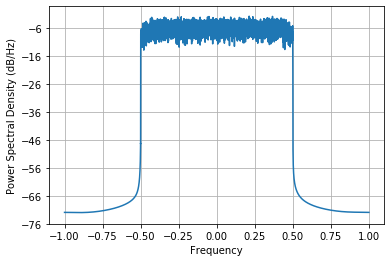

In [111]:
signal.psd()

In [62]:
import tqdm
signals = [QamSignal(4,35e9,2,44,65536,2) for _ in range(2)]
for index in tqdm.tqdm(range(2)):
    signals[index].prepare(0.2,True)
    
lasers = [Laser(10e5,False,193.1e12 + i*50e9) for i in range(2)]
lasers[0].freq = 193.1e12
lasers[1].freq = 193.1e12 + 14*50e9
center_freq = (193.1e12 + 193.1e12 + 14*50e9)/2
for laser,signal in zip(lasers,signals):
    signal = laser.prop(signal)

relative_freq = np.array([signal.freq - center_freq for signal in signals ])
samples = Mux.mux_signal(signals,relative_freq,np.array([1,14]))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


In [63]:
samples.wdm_comb_config.tolist().index(14)

1

In [156]:
def symbol2bin(symbol, width):
    symbol = np.atleast_2d(symbol)[0]
    biterror = np.empty((len(symbol),width),dtype = np.bool)
    new_symbol = symbol.copy()
    new_symbol.shape = -1,1
    for i in np.arange(width):
        biterror[:,i] = ((new_symbol >> i)&1)[:,0]
    
    
    return biterror


def calc_ber(rx_symbols,tx_symbols,qam_order):
    nbit = int(np.log2(qam_order))
    if 2**nbit <= np.max(rx_symbols) or 2**nbit<=np.max(tx_symbols):
        raise Exception("Qam order is wrong")
        
    rx_symbols = np.atleast_2d(rx_symbols)[0]
    tx_symbols = np.atleast_2d(tx_symbols)[0]
    mask = rx_symbols != tx_symbols
    
    
    error1 = symbol2bin(rx_symbols[mask],nbit)
    error2 = symbol2bin(tx_symbols[mask],nbit)
    error_num = np.sum(np.logical_xor(error1,error2))
    return error_num/(len(rx_symbols)*nbit)
    
import numpy as np

In [157]:
tx = np.random.randint(0,15,(1,65536))
rx = np.random.randint(0,15,(1,65536))
import time
now = time.time()
calc_ber(rx,tx,16)


0.49720001220703125

In [ ]:
#### equalizer

In [16]:
### 简单的CMA


def _segment_axis(a, length, overlap, mode='cut', append_to_end=0):
    """
        Generate a new array that chops the given array along the given axis into
        overlapping frames.

        example:
        >>> segment_axis(arange(10), 4, 2)
        array([[0, 1, 2, 3],
               [2, 3, 4, 5],
               [4, 5, 6, 7],
               [6, 7, 8, 9]])

        arguments:
        a       The array to segment must be 1d-array
        length  The length of each frame
        overlap The number of array elements by which the frames should overlap

        end     What to do with the last frame, if the array is not evenly
                divisible into pieces. Options are:

                'cut'   Simply discard the extra values
                'pad'   Pad with a constant value

        append_to_end:    The value to use for end='pad'

        a new array will be returned.

    """
    if hasattr(a,'device'):
        import cupy as np
    else:
        import numpy as np
    if a.ndim !=1:
        raise Exception("Error, input array must be 1d")
    if overlap > length:
        raise Exception("overlap cannot exceed the whole length")

    stride = length - overlap
    row = 1
    total_number = length
    while True:
        total_number = total_number + stride
        if total_number > len(a):
            break
        else:
            row = row + 1

    # 一共要分成row行
    if total_number > len(a):
        if mode == 'cut':
            b = np.zeros((row, length), dtype=np.complex128)
            is_append_to_end = False
        else:
            b = np.zeros((row + 1, length), dtype=np.complex128)
            is_append_to_end = True
    else:
        b = np.zeros((row, length), dtype=np.complex128)
        is_append_to_end = False

    index = 0
    for i in range(row):
        b[i, :] = a[index:index + length]
        index = index + stride

    if is_append_to_end:
        last = a[index:]

        b[row, 0:len(last)] = last
        b[row, len(last):] = append_to_end

    return b


import pdb

import numpy as np
import numba  
from numba import complex128,double
cma_core_type = \
    [(complex128[:, :], complex128[:, :], complex128[:, :], complex128[:, :], complex128[:, :], complex128[:, :], double)]

@numba.njit(cma_core_type, cache=True)
def cma_equalize_core(ex, ey, wxx, wyy, wxy, wyx, mu):
    # symbols = np.zeros((1,ex.shape[0]),dtype=np.complex128)
    symbols = np.zeros((2, ex.shape[0]), dtype=np.complex128)

    error_xpol_array = np.zeros((1, ex.shape[0]), dtype=np.float64)
    error_ypol_array = np.zeros((1, ex.shape[0]), dtype=np.float64)

    for idx in range(len(ex)):
        xx = ex[idx][::-1]
        yy = ey[idx][::-1]
        xout = np.sum(wxx * xx) + np.sum(wxy * yy)
        yout = np.sum(wyx * xx) + np.sum(wyy * yy)
        symbols[0, idx] = xout
        symbols[1, idx] = yout
        error_xpol = 1 - np.abs(xout) ** 2
        error_ypol = 1 - np.abs(yout) ** 2
        error_xpol_array[0, idx] = error_xpol
        error_xpol_array[0, idx] = error_ypol
        wxx = wxx + mu * error_xpol * xout * np.conj(xx)
        wxy = wxy + mu * error_xpol * xout * np.conj(yy)
        wyx = wyx + mu * error_ypol * yout * np.conj(xx)
        wyy = wyy + mu * error_ypol * yout * np.conj(yy)

    return symbols, wxx, wxy, wyx, wyy, error_xpol_array, error_ypol_array

class Equalizer(object):
    def __init__(self,ntaps,lr,loops):
        self.wxx = np.zeros((1,ntaps),dtype = np.complex)
        self.wxy = np.zeros((1,ntaps),dtype = np.complex)

        self.wyx = np.zeros((1,ntaps),dtype = np.complex)

        self.wyy = np.zeros((1,ntaps),dtype = np.complex)

        self.wxx[0,ntaps//2] = 1
        self.wyy[0,ntaps//2] = 1
        
        self.ntaps = ntaps
        self.lr = lr
        self.loops = loops
        self.error_xpol_array = None
        self.error_ypol_array = None
        
        self.equalized_symbols = None
        
    def equalize(self,signal):
        
        raise NotImplementedError
        
    def scatterplot(self,sps=1):
        import matplotlib.pyplot as plt
        fignumber = self.equalized_symbols.shape[0]
        fig,axes = plt.subplots(nrows = 1,ncols = fignumber)
        for ith,ax in enumerate(axes):
            ax.scatter(self.equalized_symbols[ith,::sps].real,self.equalized_symbols[ith,::sps].imag,s=1,c='b')
            ax.set_aspect('equal', 'box')

            ax.set_xlim([self.equalized_symbols[ith,::sps].real.min()-0.1,self.equalized_symbols[ith,::sps].real.max()+0.1])
            ax.set_ylim([self.equalized_symbols[ith,::sps].imag.min()-0.1,self.equalized_symbols[ith,::sps].imag.max()+0.1])

        plt.tight_layout()
        plt.show()
    
    def plot_error(self):
        fignumber = self.equalized_symbols.shape[0]
        fig,axes = plt.subplots(figsize=(8,4),nrows = 1,ncols = fignumber)
        for ith,ax in enumerate(axes):
            ax.plot(self.error_xpol_array[0],c='b',lw=1)
#             ax.set_xlim([self.equalized_symbols[ith,::sps].real.min()-0.1,self.equalized_symbols[ith,::sps].real.max()+0.1])
#             ax.set_ylim(0,self.error_xpol_array[0].max())

        plt.tight_layout()
        plt.show()
        
    def plot_freq_response(self):
        from scipy.fftpack import fft,fftshift
        freq_res =  fftshift(fft(self.wxx)),fftshift(fft(self.wxy)),fftshift(fft(self.wyx)),fftshift(fft(self.wyy))
        import matplotlib.pyplot as plt
        fig,axes = plt.subplots(2,2)
        for idx,row in enumerate(axes.flatten()):
            row.plot(np.abs(freq_res[idx][0]))
            row.set_title(f"{['wxx','wxy','wyx','wyy'][idx]}")
        plt.tight_layout()
        plt.show()
        
    def freq_response(self):
        from scipy.fftpack import fft,fftshift
        freq_res =  fftshift(fft(self.wxx)),fftshift(fft(self.wxy)),fftshift(fft(self.wyx)),fftshift(fft(self.wyy))
        return freq_res

    
class CMA(Equalizer):
    
    
    def __init__(self,ntaps,lr,loops=3):
        super().__init__(ntaps,lr,loops)
       
        
    
    def equalize(self,signal):
        signal.cpu()
        import numpy as np
            
        samples_xpol = _segment_axis(signal[0],self.ntaps, self.ntaps-signal.sps)
        samples_ypol = _segment_axis(signal[1],self.ntaps, self.ntaps-signal.sps)
        
        self.error_xpol_array = np.zeros((self.loops,len(samples_xpol)))
        self.error_ypol_array = np.zeros((self.loops,len(samples_xpol)))
        
        for idx in range(self.loops):
            symbols, self.wxx, self.wxy, self.wyx, self.wyy, error_xpol_array, error_ypol_array = cma_equalize_core(samples_xpol,
                                                                                           samples_ypol,self.wxx,self.wyy,self.wxy,self.wyx,self.lr)
            self.error_xpol_array[idx] = np.abs(error_xpol_array[0])**2
            self.error_ypol_array[idx] = np.abs(error_ypol_array[0])**2
        
        self.equalized_symbols = symbols

    
   


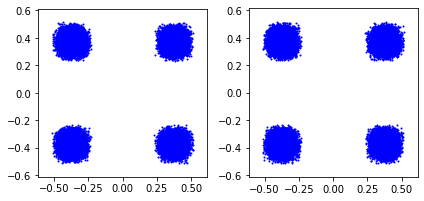

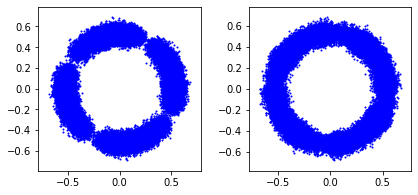

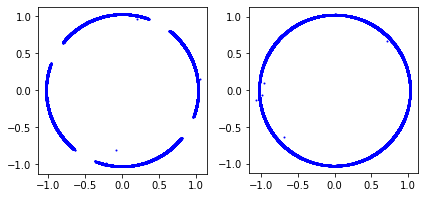

2.3836283683776855


In [17]:
signal = QamSignal(4,35e9,2,4,65536,2)
signal.prepare(0.2,True)
from receiver_dsp import matched_filter

signal.scatterplot(4)
laser = Laser(100e3,True,freq = 193.1e12)
signal = laser.prop(signal)

signal.scatterplot(4)

signal.cpu()

# resample

Resampler.prop(signal,signal.baudrate * 2)
from receiver_dsp import matched_filter
signal = matched_filter(signal,0.2)
signal[:] = signal[:]/np.sqrt(np.mean(np.abs(signal[:])**2,axis=1,keepdims=True))
import time
now = time.time()
signal.scatterplot(2)


cma = CMA(321,0.001,3)
cma.equalize(signal)
print(time.time()-now)

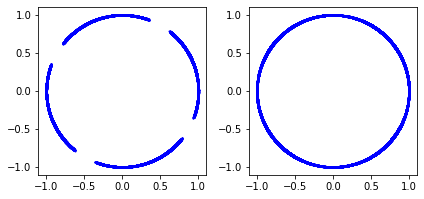

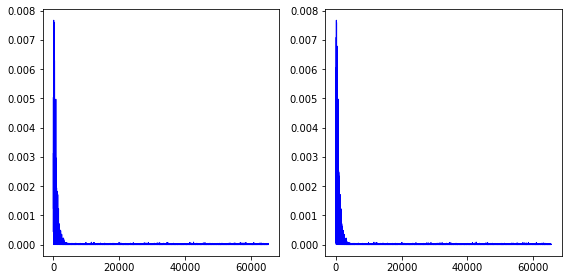

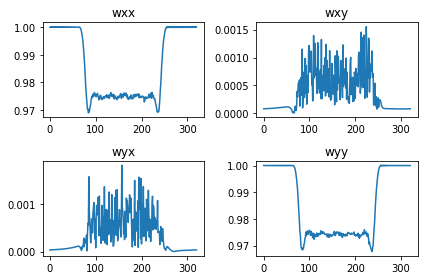

In [18]:
import matplotlib.pyplot as plt
cma.scatterplot()
cma.plot_error()
cma.plot_freq_response()

In [40]:

def __segment_axis(a, length, overlap, mode='cut', append_to_end=0):
    """
        Generate a new array that chops the given array along the given axis into
        overlapping frames.

        example:
        >>> segment_axis(arange(10), 4, 2)
        array([[0, 1, 2, 3],
               [2, 3, 4, 5],
               [4, 5, 6, 7],
               [6, 7, 8, 9]])

        arguments:
        a       The array to segment must be 1d-array
        length  The length of each frame
        overlap The number of array elements by which the frames should overlap

        end     What to do with the last frame, if the array is not evenly
                divisible into pieces. Options are:

                'cut'   Simply discard the extra values
                'pad'   Pad with a constant value

        append_to_end:    The value to use for end='pad'

        a new array will be returned.

    """
    if hasattr(a,'device'):
        import cupy as np
    else:
        import numpy as np
    if a.ndim !=1:
        raise Exception("Error, input array must be 1d")
    if overlap > length:
        raise Exception("overlap cannot exceed the whole length")

    stride = length - overlap
    row = 1
    total_number = length
    while True:
        total_number = total_number + stride
        if total_number > len(a):
            break
        else:
            row = row + 1

    # 一共要分成row行
    if total_number > len(a):
        if mode == 'cut':
            b = np.zeros((row, length), dtype=np.complex128)
            is_append_to_end = False
        else:
            b = np.zeros((row + 1, length), dtype=np.complex128)
            is_append_to_end = True
    else:
        b = np.zeros((row, length), dtype=np.complex128)
        is_append_to_end = False

    index = 0
    for i in range(row):
        b[i, :] = a[index:index + length]
        index = index + stride

    if is_append_to_end:
        last = a[index:]

        b[row, 0:len(last)] = last
        b[row, len(last):] = append_to_end

    return b


In [170]:
__segment_axis(cp.array([0,1,2,3,4,5,6]),4,2)

array([[0.+0.j, 1.+0.j, 2.+0.j, 3.+0.j],
       [2.+0.j, 3.+0.j, 4.+0.j, 5.+0.j]])

In [167]:
import cupy as cp

In [185]:
10e5

1000000.0

# 100e3

In [186]:
100e3

100000.0

In [197]:
signal.samples.shape

(2, 131072)

In [14]:
np.array(signal.symbol).shape

(2, 65536)

In [19]:
cp.array(None)

ValueError: Unsupported dtype object

In [115]:
matched_filter??

Signature: matched_filter(signal, roll_off)
Docstring: <no docstring>
Source:   
def matched_filter(signal,roll_off):
    if signal.is_on_cuda:
        import cupy as np
    else:
        import numpy as np
    samples = np.copy(signal[:])
    for row in samples:
        row[:] = rrcos_pulseshaping_freq(row,signal.fs,1/signal.baudrate,roll_off,signal.is_on_cuda)
    signal[:] = samples
    return signal
File:      c:\users\shang\simulator\receiver_dsp.py
Type:      function


In [191]:
['wxx','wxy','wyx','wyy']

['wxx', 'wxy', 'wyx', 'wyy']

In [ ]:
dd
